Help is taken from notebook : https://www.kaggle.com/artgor/eda-feature-engineering-and-model-interpretation 

In [1]:
import numpy as np
import eli5
import lightgbm as lgb
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import ast
from sklearn.model_selection import train_test_split
from collections import Counter
import wordcloud
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

In [2]:
data=r"C:\Users\bhardwaj\Downloads\tmdb-box-office-prediction\train.csv"

In [3]:
df=pd.read_csv(data)

In [4]:
df.set_index('id',inplace=True)

In [5]:
df.isnull().sum()

belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

In [6]:
df.dtypes

belongs_to_collection     object
budget                     int64
genres                    object
homepage                  object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity               float64
poster_path               object
production_companies      object
production_countries      object
release_date              object
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
Keywords                  object
cast                      object
crew                      object
revenue                    int64
dtype: object

In [7]:
for i, e in enumerate(df['genres'][:10]):
    print(i, e)

0 [{'id': 35, 'name': 'Comedy'}]
1 [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'id': 10749, 'name': 'Romance'}]
2 [{'id': 18, 'name': 'Drama'}]
3 [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'name': 'Drama'}]
4 [{'id': 28, 'name': 'Action'}, {'id': 53, 'name': 'Thriller'}]
5 [{'id': 16, 'name': 'Animation'}, {'id': 12, 'name': 'Adventure'}, {'id': 10751, 'name': 'Family'}]
6 [{'id': 27, 'name': 'Horror'}, {'id': 53, 'name': 'Thriller'}]
7 [{'id': 99, 'name': 'Documentary'}]
8 [{'id': 28, 'name': 'Action'}, {'id': 35, 'name': 'Comedy'}, {'id': 10402, 'name': 'Music'}, {'id': 10751, 'name': 'Family'}, {'id': 12, 'name': 'Adventure'}]
9 [{'id': 35, 'name': 'Comedy'}, {'id': 10402, 'name': 'Music'}]


In [8]:
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

In [9]:
def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df

In [10]:
df = text_to_dict(df)
df['genres']

id
1                          [{'id': 35, 'name': 'Comedy'}]
2       [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
3                           [{'id': 18, 'name': 'Drama'}]
4       [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...
5       [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...
6       [{'id': 16, 'name': 'Animation'}, {'id': 12, '...
7       [{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...
8                     [{'id': 99, 'name': 'Documentary'}]
9       [{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...
10      [{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...
11                          [{'id': 18, 'name': 'Drama'}]
12                         [{'id': 35, 'name': 'Comedy'}]
13                          [{'id': 18, 'name': 'Drama'}]
14      [{'id': 35, 'name': 'Comedy'}, {'id': 80, 'nam...
15      [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...
16      [{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...
17      [{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...
18      [{'

###### Creating dummy has_collection for the movies that actually belongs to collection.

In [11]:
df['has_collection'] = df['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)

In [12]:
df['has_collection'].value_counts()

0    2396
1     604
Name: has_collection, dtype: int64

###### There are many movies with more than 1 genre. Therefore let's account for 15 most common genres in movies and how having this genre affect revenue.

In [13]:
print('Number of genres in films')
df['genres'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Number of genres in films


2    972
3    900
1    593
4    393
5    111
6     21
0      7
7      3
Name: genres, dtype: int64

In [14]:
list_of_genres = list(df['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

In [15]:
text = ' '.join([i for j in list_of_genres for i in j]) ## here we created a text with the every genre in it to create word cloud.

In [16]:
wordcloud=WordCloud(collocations=False).generate(text)

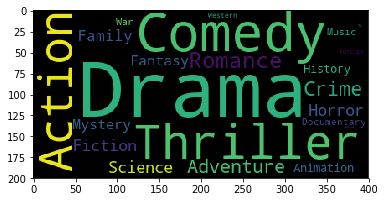

In [17]:
plt.imshow(wordcloud)

Comedy, Drama and Thriller are some of the most common genres.

In [18]:
df['num_genres'] = df['genres'].apply(lambda x: len(x) if x != {} else 0)
df['all_genres']=df['genres'].apply(lambda x: " ".join(sorted([i['name'] for i in x])) if x != {} else '') ## Added space in the quotes to add space between genres
top_genres = [m[0] for m in Counter([i for j in list_of_genres for i in j]).most_common(15)] ## with m[0] I only took the name of genres in top 15 list and not the column of counts.
for g in top_genres:
    df['genre_' + g] = df['all_genres'].apply(lambda x: 1 if g in x else 0)
## So here created dummy for top 15 genres.

###### Similarly creating dummies for top 20 most common languages movie is released in and top 20 most common production companies and countries.

In [19]:
df['original_language'].value_counts()
for i, e in enumerate(df['spoken_languages'][:10]):
    print(i, e)
    print('Number of languages film is released in ')
df['spoken_languages'].apply(lambda x: len(x) if x != {} else 0).value_counts()
## most of the movies are released in only 1 language.
list_of_languages = list(df['spoken_languages'].apply(lambda x: [i['iso_639_1'] for i in x] if x != {} else []).values)
df['num_lan'] = df['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
df['all_lan']=df['spoken_languages'].apply(lambda x: " ".join(sorted([i['iso_639_1'] for i in x])) if x != {} else '') ## Added space in the quotes to add space between genres
spok_lang = [m[0] for m in Counter([i for j in list_of_languages for i in j]).most_common(20)] ## with m[0] I only took the name of genres in top 15 list and not the column of counts.
for g in spok_lang:
    df['spoken_language_' + g] = df['all_lan'].apply(lambda x: 1 if g in x else 0)


0 [{'iso_639_1': 'en', 'name': 'English'}]
Number of languages film is released in 
1 [{'iso_639_1': 'en', 'name': 'English'}]
Number of languages film is released in 
2 [{'iso_639_1': 'en', 'name': 'English'}]
Number of languages film is released in 
3 [{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'hi', 'name': 'हिन्दी'}]
Number of languages film is released in 
4 [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]
Number of languages film is released in 
5 [{'iso_639_1': 'en', 'name': 'English'}]
Number of languages film is released in 
6 [{'iso_639_1': 'en', 'name': 'English'}]
Number of languages film is released in 
7 [{'iso_639_1': 'ar', 'name': 'العربية'}, {'iso_639_1': 'en', 'name': 'English'}]
Number of languages film is released in 
8 [{'iso_639_1': 'en', 'name': 'English'}]
Number of languages film is released in 
9 [{'iso_639_1': 'en', 'name': 'English'}]
Number of languages film is released in 


In [20]:
print('No. of production companies ')
print(df['production_companies'].apply(lambda x: len(x) if x != {} else 0).value_counts())
list_of_companies = list(df['production_companies'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
df['num_pcomp'] = df['production_companies'].apply(lambda x: len(x) if x != {} else 0)
df['all_pcomp']=df['production_companies'].apply(lambda x: " ".join(sorted([i['name'] for i in x])) if x != {} else '') ## Added space in the quotes to add space between genres
top_prod_comp=[m[0] for m in Counter([i for j in list_of_companies for i in j]).most_common(20)] ## with m[0] I only took the name of genres in top 15 list and not the column of counts.
for g in top_prod_comp:
    df['prod_comp_' + g] = df['all_pcomp'].apply(lambda x: 1 if g in x else 0)

No. of production companies 
1     775
2     734
3     582
4     312
5     166
0     156
6     118
7      62
8      42
9      29
11      7
10      7
12      3
16      2
15      2
14      1
13      1
17      1
Name: production_companies, dtype: int64


In [21]:
print('No. of production countries ')
print(df['production_countries'].apply(lambda x: len(x) if x != {} else 0).value_counts())
list_of_countries = list(df['production_countries'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
df['num_pcoun'] = df['production_companies'].apply(lambda x: len(x) if x != {} else 0)
df['all_pcoun']=df['production_companies'].apply(lambda x: " ".join(sorted([i['name'] for i in x])) if x != {} else '') ## Added space in the quotes to add space between genres
top_prod_coun=[m[0] for m in Counter([i for j in list_of_countries for i in j]).most_common(20)] ## with m[0] I only took the name of genres in top 15 list and not the column of counts.
for g in top_prod_coun:
    df['prod_coun_' + g] = df['all_pcoun'].apply(lambda x: 1 if g in x else 0)

No. of production countries 
1    2222
2     525
3     116
4      57
0      55
5      21
6       3
8       1
Name: production_countries, dtype: int64


In [22]:
df['status'].value_counts()

Released    2996
Rumored        4
Name: status, dtype: int64

Since almost all the movies are release, it does not seem beneficial to keep this variable.

In [23]:
print('No. of key words ')
print(df['Keywords'].apply(lambda x: len(x) if x != {} else 0).value_counts())
list_of_keywords = list(df['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
df['num_keyword'] = df['Keywords'].apply(lambda x: len(x) if x != {} else 0)
df['all_keyword']=df['Keywords'].apply(lambda x: " ".join(sorted([i['name'] for i in x])) if x != {} else '') ## Added space in the quotes to add space between genres
top_keyword=[m[0] for m in Counter([i for j in list_of_keywords for i in j]).most_common(20)]
for g in top_keyword:
    df['keyword_' + g] = df['all_keyword'].apply(lambda x: 1 if g in x else 0)

No. of key words 
5      293
0      276
4      248
3      228
6      227
2      207
7      192
1      187
8      161
9      134
11     132
10     125
12     100
13      85
14      59
15      59
16      58
17      45
18      29
20      24
21      23
19      22
22      17
23      15
24      12
27      12
25       6
26       5
32       2
28       2
30       2
31       2
29       2
37       2
43       1
40       1
38       1
33       1
97       1
39       1
149      1
Name: Keywords, dtype: int64


###### Extracting 20 most common actors from the cast variable and their gender.

In [24]:
print('No. of actors ')
print(df['cast'].apply(lambda x: len(x) if x != {} else 0).value_counts())
list_of_cast = list(df['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
print('Gender of actors ')
print(df['cast'].apply(lambda x: len(x) if x != {} else 0).value_counts())
list_of_gcast = list(df['cast'].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)

No. of actors 
15     212
16     165
10     135
13     129
12     124
11     122
9      118
17     118
18     115
14     110
8      106
19     102
7       96
20      93
22      77
6       76
23      71
21      68
5       57
24      57
4       52
25      50
27      44
29      42
26      39
31      37
30      32
28      30
32      26
0       26
      ... 
69       2
98       2
75       2
76       2
117      2
77       2
105      2
80       2
103      1
95       1
81       1
89       1
87       1
85       1
113      1
83       1
115      1
91       1
64       1
156      1
122      1
118      1
112      1
108      1
92       1
90       1
88       1
84       1
82       1
134      1
Name: cast, Length: 109, dtype: int64
Gender of actors 
15     212
16     165
10     135
13     129
12     124
11     122
9      118
17     118
18     115
14     110
8      106
19     102
7       96
20      93
22      77
6       76
23      71
21      68
5       57
24      57
4       52
25      50
27      44
29   

In [25]:
df['num_cast'] = df['cast'].apply(lambda x: len(x) if x != {} else 0)
df['all_cast']=df['cast'].apply(lambda x: " ".join(sorted([i['name'] for i in x])) if x != {} else '') ## Added space in the quotes to add space between genres
top_cast=[m[0] for m in Counter([i for j in list_of_cast for i in j]).most_common(20)] ## with m[0] I only took the name of genres in top 15 list and not the column of counts.
for g in top_cast:
    df['cast_' + g] = df['all_cast'].apply(lambda x: 1 if g in x else 0)
    list_of_cast_genders = list(df['cast'].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_genders for i in j]).most_common()
len(list_of_cast)

3000

###### Extracting 15  most common crew names and their gender from the crew variable.

In [26]:
df['crew'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)
list_of_crew_names = list(df['crew'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
print(Counter([i for j in list_of_crew_names for i in j]).most_common(15))
list_of_crew_jobs = list(df['crew'].apply(lambda x: [i['job'] for i in x] if x != {} else []).values)
print(Counter([i for j in list_of_crew_jobs for i in j]).most_common(15))
list_of_crew_genders = list(df['crew'].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)
print(Counter([i for j in list_of_crew_genders for i in j]).most_common(15))
list_of_crew_departments = list(df['crew'].apply(lambda x: [i['department'] for i in x] if x != {} else []).values)
print(Counter([i for j in list_of_crew_departments for i in j]).most_common(14))
list_of_crew_names = df['crew'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values

[('Avy Kaufman', 50), ('Robert Rodriguez', 44), ('Deborah Aquila', 40), ('James Newton Howard', 39), ('Mary Vernieu', 38), ('Steven Spielberg', 37), ('Luc Besson', 37), ('Jerry Goldsmith', 37), ('Francine Maisler', 35), ('Tricia Wood', 35), ('James Horner', 33), ('Kerry Barden', 32), ('Bob Weinstein', 30), ('Harvey Weinstein', 30), ('Janet Hirshenson', 30)]
[('Producer', 6011), ('Executive Producer', 3459), ('Director', 3225), ('Screenplay', 2996), ('Editor', 2824), ('Casting', 2483), ('Director of Photography', 2288), ('Original Music Composer', 1947), ('Art Direction', 1821), ('Production Design', 1650), ('Costume Design', 1573), ('Writer', 1523), ('Set Decoration', 1345), ('Makeup Artist', 1108), ('Sound Re-Recording Mixer', 970)]
[(0, 41787), (2, 24898), (1, 6412)]
[('Production', 15887), ('Sound', 9319), ('Art', 8069), ('Crew', 7315), ('Writing', 6567), ('Costume & Make-Up', 6156), ('Camera', 5424), ('Directing', 4954), ('Editing', 4508), ('Visual Effects', 3591), ('Lighting', 130

In [27]:
df['num_crew'] = df['crew'].apply(lambda x: len(x) if x != {} else 0)
top_crew_names = [m[0] for m in Counter([i for j in list_of_crew_names for i in j]).most_common(15)]
for g in top_crew_names:
    df['crew_name_' + g] = df['crew'].apply(lambda x: 1 if g in str(x) else 0)
df['genders_0_crew'] = df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
df['genders_1_crew'] = df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
df['genders_2_crew'] = df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
top_crew_jobs = [m[0] for m in Counter([i for j in list_of_crew_jobs for i in j]).most_common(15)]
for j in top_crew_jobs:
    df['jobs_' + j] = df['crew'].apply(lambda x: sum([1 for i in x if i['job'] == j]))
top_crew_departments = [m[0] for m in Counter([i for j in list_of_crew_departments for i in j]).most_common(15)]
for j in top_crew_departments:
    df['departments_' + j] = df['crew'].apply(lambda x: sum([1 for i in x if i['department'] == j])) 

###### Extracting the year in which movie is released and month in which movie is released.

In [28]:
def fix_date(x):
    """
    Fixes dates which are in 20xx
    """
    year = x.split('/')[2]
    if int(year) <= 19:
        return x[:-2] + '20' + year
    else:
        return x[:-2] + '19' + year


In [29]:
df['release_date'] = df['release_date'].apply(lambda x: fix_date(x))
df['release_date'] = pd.to_datetime(df['release_date'])

In [30]:
def process_date(data):
    date_parts = ["year", "weekday", "month", 'weekofyear', 'day', 'quarter']
    for part in date_parts:
        part_col = 'release_date' + "_" + part
        data[part_col] = getattr(data['release_date'].dt, part).astype(int)
        return data

In [31]:
process_date(df)

,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,...,departments_Crew,departments_Writing,departments_Costume & Make-Up,departments_Camera,departments_Directing,departments_Editing,departments_Visual Effects,departments_Lighting,departments_Actors,release_date_year
id,,,,,,,,,,,,,,,,,,,,,
1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,...,4,2,13,8,4,2,4,4,0,2015
2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,...,0,1,0,1,1,1,0,0,0,2004
3,{},3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,...,9,1,5,4,3,6,3,1,0,2014
4,{},1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,...,0,1,0,0,1,0,0,0,0,2012
5,{},0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,...,0,1,0,0,1,0,0,0,0,2009
6,{},8000000,"[{'id': 16, 'name': 'Animation'}, {'id': 12, '...",NaN,tt0093743,en,Pinocchio and the Emperor of the Night,"Pinocchio and his friends, a glow worm and a m...",0.743274,/6IDqA1D2NBIVhzEEaMMRL28iBrq.jpg,...,0,4,0,0,1,0,4,0,0,1987
7,{},14000000,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...",http://www.thepossessionmovie.com/,tt0431021,en,The Possession,A young girl buys an antique box at a yard sal...,7.286477,/4QjzFuaZmB4btGnLwAgdp23BzIU.jpg,...,11,4,12,11,4,9,2,4,0,2012
8,{},0,"[{'id': 99, 'name': 'Documentary'}]",NaN,tt0391024,en,Control Room,A chronicle which provides a rare window into ...,1.949044,/83BV8fGy5p9i8RwE9oj76tZ1Ikp.jpg,...,0,0,0,0,1,0,0,0,0,2004
9,"[{'id': 256377, 'name': 'The Muppet Collection...",0,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",NaN,tt0117110,en,Muppet Treasure Island,After telling the story of Flint's last journe...,6.902423,/5A8gKzOrF9Z7tSUX6xd5dEx4NXf.jpg,...,0,2,0,1,1,1,0,0,0,1996


In [32]:
df['release_month']=getattr(df['release_date'].dt,'month')

In [33]:
df['release_year']=getattr(df['release_date'].dt,'year')

In [34]:
df['release_year'].value_counts()

2013    141
2015    128
2010    126
2016    125
2012    125
2011    124
2014    123
2006    114
2009    106
2007    105
2008    101
2005     99
2002     84
2004     83
2001     77
2003     74
1998     66
1999     65
2000     65
1997     63
1995     62
1993     56
1988     56
1996     55
1994     51
1989     47
1990     46
1992     45
1987     45
1986     44
       ... 
1959      5
1956      4
1936      4
1951      4
1965      4
1961      4
1945      4
1939      4
1958      3
1957      3
1942      3
1928      3
1932      3
1940      2
1944      2
1950      2
1949      2
1943      2
1933      2
1931      2
1927      2
1925      2
1947      2
1926      1
1930      1
1952      1
1938      1
1935      1
1921      1
1924      1
Name: release_year, Length: 90, dtype: int64

In [35]:
df.describe()

,budget,popularity,runtime,revenue,has_collection,num_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,...,departments_Costume & Make-Up,departments_Camera,departments_Directing,departments_Editing,departments_Visual Effects,departments_Lighting,departments_Actors,release_date_year,release_month,release_year
count,3.000000e+03,3000.000000,2998.000000,3.000000e+03,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,...,3000.00000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,2.253133e+07,8.463274,107.856571,6.672585e+07,0.201333,2.503667,0.510333,0.342667,0.263000,0.247000,...,2.05200,1.808000,1.651333,1.502667,1.197000,0.434333,0.001333,1999.713000,6.775333,1999.713000
std,3.702609e+07,12.104000,22.086434,1.375323e+08,0.401063,1.117021,0.499977,0.474680,0.440336,0.431339,...,3.51142,2.560597,1.353653,1.726940,3.733475,1.235393,0.044709,15.423313,3.409115,15.423313
min,0.000000e+00,0.000001,0.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1921.000000,1.000000,1921.000000
25%,0.000000e+00,4.018053,94.000000,2.379808e+06,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1993.000000,4.000000,1993.000000
50%,8.000000e+06,7.374861,104.000000,1.680707e+07,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,...,1.00000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2004.000000,7.000000,2004.000000
75%,2.900000e+07,10.890983,118.000000,6.891920e+07,0.000000,3.000000,1.000000,1.000000,1.000000,0.000000,...,2.00000,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,2011.000000,10.000000,2011.000000
max,3.800000e+08,294.337037,338.000000,1.519558e+09,1.000000,7.000000,1.000000,1.000000,1.000000,1.000000,...,33.00000,23.000000,30.000000,14.000000,52.000000,12.000000,2.000000,2017.000000,12.000000,2017.000000


In [36]:
df.to_csv (r'C:\Users\bhardwaj\Downloads\tmdb-box-office-prediction\dataframe1.csv', header=True) #Don't forget to add '.csv' at the end of the path

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\bhardwaj\\Downloads\\tmdb-box-office-prediction\\dataframe1.csv'